In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy.stats
import numpy as np

In [28]:
import re
#From: https://stackoverflow.com/questions/4813061/non-alphanumeric-list-order-from-os-listdir
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [29]:
import re
df_list = []
glob_list = glob.glob("model_analyses\\test//"+"//**//*.csv", recursive = True) #searcg all the analyses to find the CSV's

ordered_glob_list = sorted_alphanumeric(glob_list) #problems with default ordering

for csv in ordered_glob_list:
    df_list.append([pd.read_csv(csv),csv]) #create and store a tuple which contains the dataframe and the directory
    print(csv)

model_analyses\test\aae-128_peptide_latent32_test\saved_info.csv
model_analyses\test\aae-128_peptide_latent64_test\saved_info.csv
model_analyses\test\aae-128_peptide_latent128_test\saved_info.csv
model_analyses\test\rnn-128_peptide_latent32_test\saved_info.csv
model_analyses\test\rnn-128_peptide_latent64_test\saved_info.csv
model_analyses\test\rnn-128_peptide_latent128_test\saved_info.csv
model_analyses\test\rnnattn-128_peptide_latent32_test\saved_info.csv
model_analyses\test\rnnattn-128_peptide_latent64_test\saved_info.csv
model_analyses\test\rnnattn-128_peptide_latent128_test\saved_info.csv
model_analyses\test\trans1x-128_peptide_latent32_test\saved_info.csv
model_analyses\test\trans1x-128_peptide_latent64_test\saved_info.csv
model_analyses\test\trans1x-128_peptide_latent128_test\saved_info.csv
model_analyses\test\wae-128_peptide_latent32_test\saved_info.csv
model_analyses\test\wae-128_peptide_latent64_test\saved_info.csv
model_analyses\test\wae-128_peptide_latent128_test\saved_info.

In [30]:
#some scores need confidence intervals calculated which is done below. Also the model name is appended at the end of the df
#also store the results to be printed in a "metric_list"
metric_list=[]
i=0
for df_tuple in df_list:
    entropies=df_tuple[0].loc[:,'mu_entropies']
    metric_list.append([entropies.dropna(),'latent mean entropies'])
    print(i)
    for col in df_tuple[0].loc[:,'latent_mem_func_silhouette':'latent_to_PCA_cohesiveness']:
        samples=df_tuple[0].loc[:,col]
        conf=scipy.stats.t.interval(0.95, len(samples)-1,np.mean(samples.dropna()), scipy.stats.sem(samples.dropna()))
        df_tuple[0]=pd.concat([df_tuple[0],pd.DataFrame({'{}'.format(col+' conf'):conf})], axis=1)
        metric_list.append([samples.dropna(),'{}'.format(col)])

    df_tuple[0]['model'] = df_tuple[1] #add a column with the model name
    metric_list.append(df_tuple[1])
    i+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [31]:
namelist=[sublist for sublist in metric_list if isinstance(sublist, str)] #leave the sublist only pick up strings with names
model_names = [temp_list[:].split('\\')[-2] for temp_list in namelist]
print(model_names)

['aae-128_peptide_latent32_test', 'aae-128_peptide_latent64_test', 'aae-128_peptide_latent128_test', 'rnn-128_peptide_latent32_test', 'rnn-128_peptide_latent64_test', 'rnn-128_peptide_latent128_test', 'rnnattn-128_peptide_latent32_test', 'rnnattn-128_peptide_latent64_test', 'rnnattn-128_peptide_latent128_test', 'trans1x-128_peptide_latent32_test', 'trans1x-128_peptide_latent64_test', 'trans1x-128_peptide_latent128_test', 'wae-128_peptide_latent32_test', 'wae-128_peptide_latent64_test', 'wae-128_peptide_latent128_test']


In [32]:
#shortens the names to fit well in the plots
namelist=[sublist for sublist in metric_list if isinstance(sublist, str)] #leave the sublist only pick up strings with names
model_names = [temp_list[:].split('\\')[-2] for temp_list in namelist]
model_names = [names.split('_')[0][:-4]+'-'+names.split('_')[2][6:] for names in model_names] 

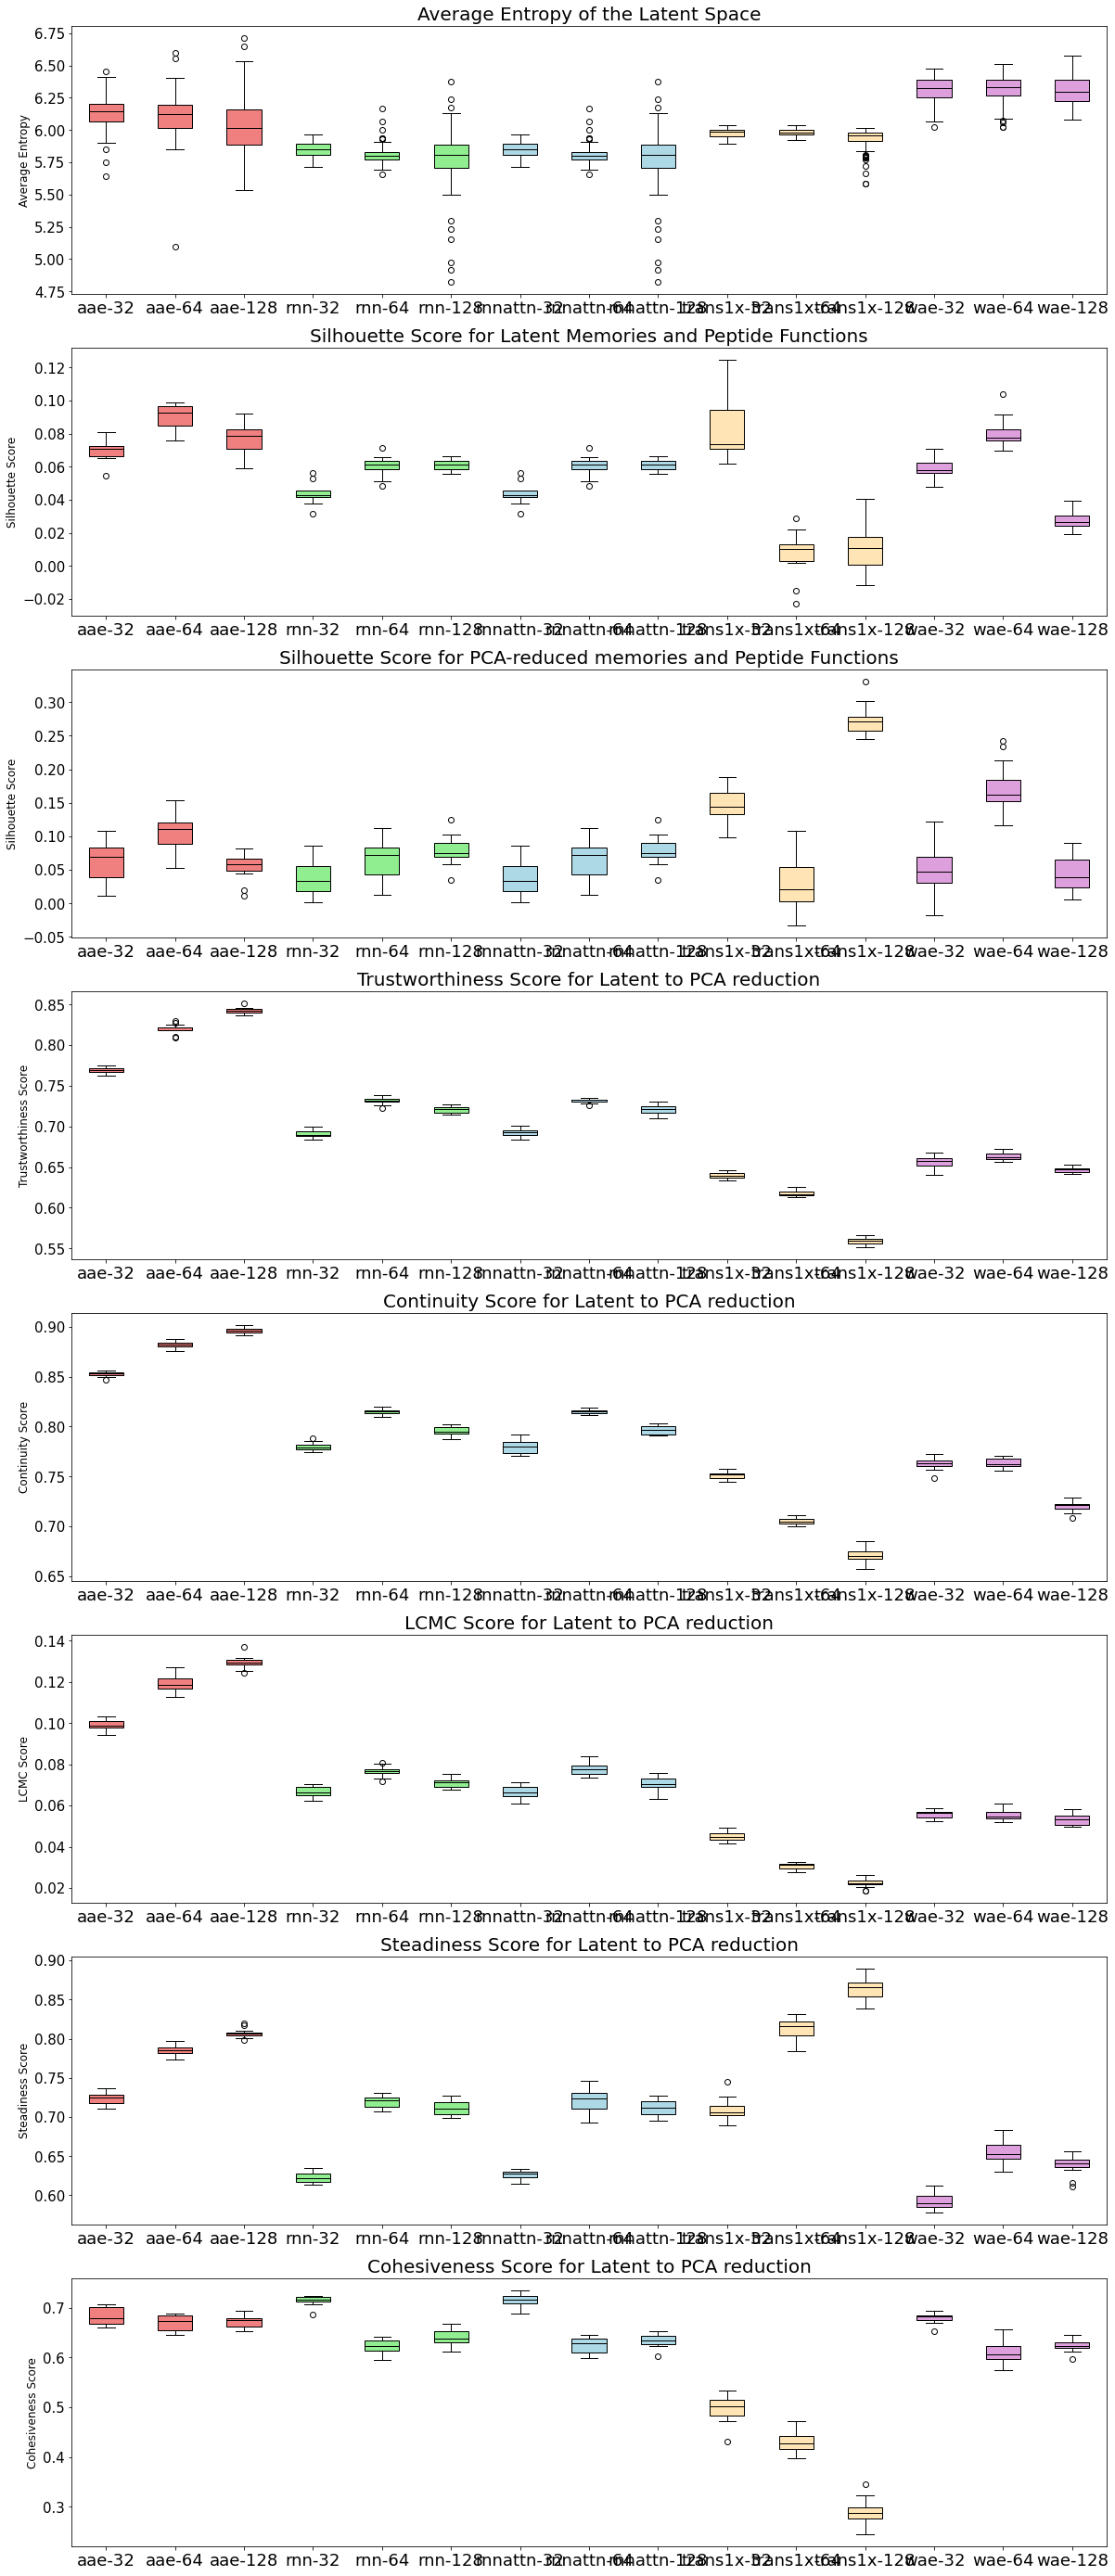

In [33]:
fig, ax = plt.subplots((len(metric_list)//len(namelist)-1),1, figsize=(20,50))

color_list =['lightcoral','lightcoral','lightcoral',
             'lightgreen','lightgreen','lightgreen',
             'lightblue','lightblue','lightblue',
             'moccasin','moccasin','moccasin',
             'plum','plum','plum']
title_list=['Average Entropy of the Latent Space', 'Silhouette Score for Latent Memories and Peptide Functions',
           'Silhouette Score for PCA-reduced memories and Peptide Functions', 
            'Trustworthiness Score for Latent to PCA reduction', 'Continuity Score for Latent to PCA reduction',
           'LCMC Score for Latent to PCA reduction', 'Steadiness Score for Latent to PCA reduction',
           'Cohesiveness Score for Latent to PCA reduction']
y_labels=['Average Entropy', 'Silhouette Score','Silhouette Score','Trustworthiness Score','Continuity Score',
         'LCMC Score','Steadiness Score', 'Cohesiveness Score']

SMALL_SIZE = 9
MEDIUM_SIZE = 14
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels


for col in range((len(metric_list)//len(namelist)-1)):
    box = ax[col].boxplot(x=[elmt[0] for elmt in metric_list[col::(len(metric_list)//len(namelist))]],
                   labels=model_names, patch_artist=True) 
    for patch,color in zip(box['boxes'],color_list): patch.set_facecolor(color)
    plt.setp(box['medians'],color='black')
#     ax[col].set_title(metric_list[col::(len(metric_list)//len(namelist))][0][-1])
    ax[col].set_title(title_list[col])
#     ax[col].set_ylabel('{}'.format(metric_list[col::(len(metric_list)//len(namelist))][0][-1]))
    ax[col].set_ylabel(y_labels[col])
plt.savefig('boxplot_metrics.jpg', transparent=None, dpi=200)
plt.show()

In [34]:
pos_acc_list = []
pos_err_list = []
for df_tuple in df_list:
    #grab 1st element of cols: 2->last
    pos_acc_list.append(df_tuple[0].loc[:,df_tuple[0].columns[0]])
    pos_err_list.append(df_tuple[0].loc[:,df_tuple[0].columns[1]])

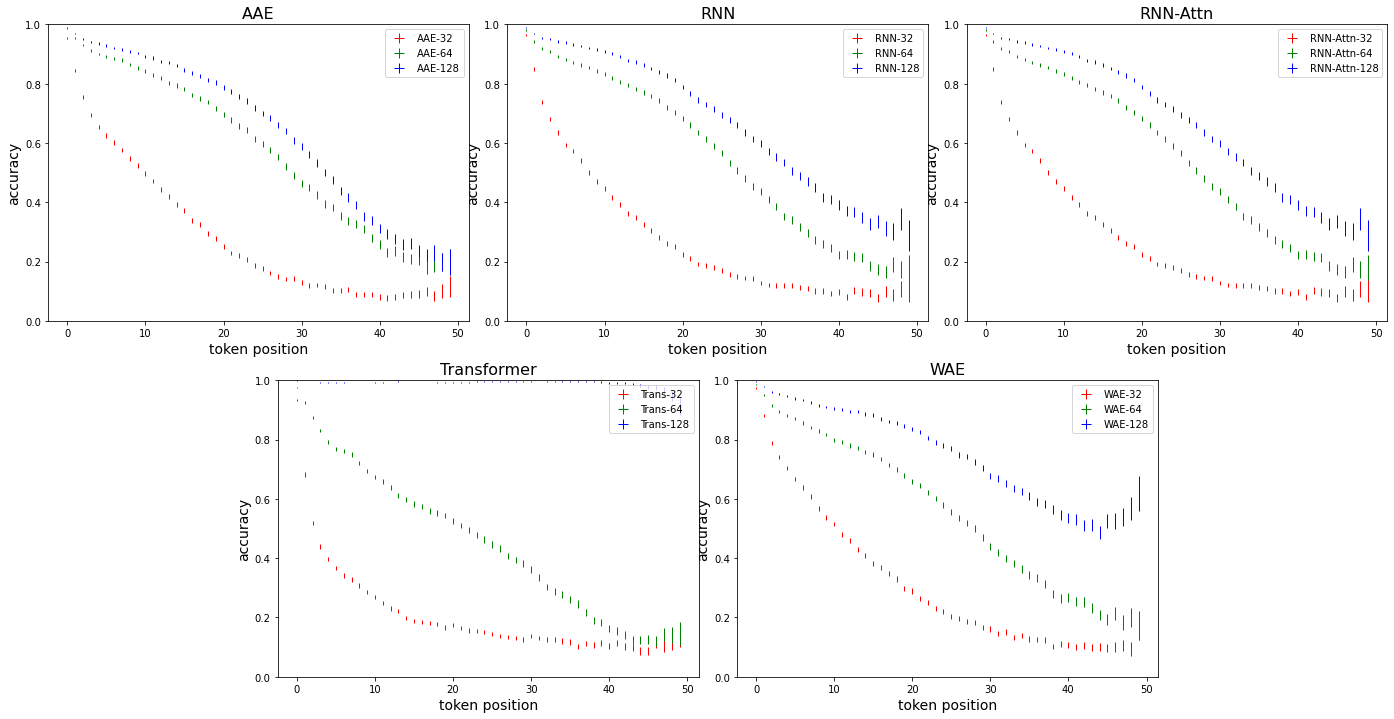

In [35]:
fig = plt.figure(figsize=(24,12))
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

lw = 1 #linewidth
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)

img = ax1.errorbar(x=range(len(pos_acc_list[0].dropna())), y=pos_acc_list[0].dropna(),
                   xerr=0,yerr=pos_err_list[0].dropna(),fmt='none',ecolor='r',elinewidth=lw)
ax1.errorbar(x=range(len(pos_acc_list[1].dropna())), y=pos_acc_list[1].dropna(),
                   xerr=0,yerr=pos_err_list[1].dropna(),fmt='none',ecolor='g',elinewidth=lw)
ax1.errorbar(x=range(len(pos_acc_list[2].dropna())), y=pos_acc_list[2].dropna(),
                   xerr=0,yerr=pos_err_list[2].dropna(),fmt='none',ecolor='b',elinewidth=lw)
ax1.set_title('AAE')
ax1.legend(['AAE-32','AAE-64','AAE-128'])
ax1.set_ylim([0, 1])
ax1.set_ylabel('accuracy')
ax1.set_xlabel('token position')
# plt.show(img)

ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax2.errorbar(x=range(len(pos_acc_list[3].dropna())), y=pos_acc_list[3].dropna(),
                   xerr=0,yerr=pos_err_list[3].dropna(),fmt='none',ecolor='r',elinewidth=lw)
ax2.errorbar(x=range(len(pos_acc_list[4].dropna())), y=pos_acc_list[4].dropna(),
                   xerr=0,yerr=pos_err_list[4].dropna(),fmt='none',ecolor='g',elinewidth=lw)
ax2.errorbar(x=range(len(pos_acc_list[5].dropna())), y=pos_acc_list[5].dropna(),
                   xerr=0,yerr=pos_err_list[5].dropna(),fmt='none',ecolor='b',elinewidth=lw)
ax2.set_title('RNN')
ax2.legend(['RNN-32','RNN-64','RNN-128'])
ax2.set_ylim([0, 1])
ax2.set_ylabel('accuracy')
ax2.set_xlabel('token position')
# plt.show(img)

ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax3.errorbar(x=range(len(pos_acc_list[6].dropna())), y=pos_acc_list[6].dropna(),
                   xerr=0,yerr=pos_err_list[6].dropna(),fmt='none',ecolor='r',elinewidth=lw)
ax3.errorbar(x=range(len(pos_acc_list[7].dropna())), y=pos_acc_list[7].dropna(),
                   xerr=0,yerr=pos_err_list[7].dropna(),fmt='none',ecolor='g',elinewidth=lw)
ax3.errorbar(x=range(len(pos_acc_list[8].dropna())), y=pos_acc_list[8].dropna(),
                   xerr=0,yerr=pos_err_list[8].dropna(),fmt='none',ecolor='b',elinewidth=lw)
ax3.set_title('RNN-Attn')
ax3.legend(['RNN-Attn-32','RNN-Attn-64','RNN-Attn-128'])
ax3.set_ylim([0, 1])
ax3.set_ylabel('accuracy')
ax3.set_xlabel('token position')
# plt.show(img)

ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax4.errorbar(x=range(len(pos_acc_list[9].dropna())), y=pos_acc_list[9].dropna(),
                   xerr=0,yerr=pos_err_list[9].dropna(),fmt='none',ecolor='r',elinewidth=lw)
ax4.errorbar(x=range(len(pos_acc_list[10].dropna())), y=pos_acc_list[10].dropna(),
                   xerr=0,yerr=pos_err_list[10].dropna(),fmt='none',ecolor='g',elinewidth=lw)
ax4.errorbar(x=range(len(pos_acc_list[11].dropna())), y=pos_acc_list[11].dropna(),
                   xerr=0,yerr=pos_err_list[11].dropna(),fmt='none',ecolor='b',elinewidth=lw)
ax4.set_title('Transformer')
ax4.legend(['Trans-32','Trans-64','Trans-128'])
ax4.set_ylim([0, 1])
ax4.set_ylabel('accuracy')
ax4.set_xlabel('token position')
# plt.show(img)

ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
ax5.errorbar(x=range(len(pos_acc_list[12].dropna())), y=pos_acc_list[12].dropna(),
                   xerr=0,yerr=pos_err_list[12].dropna(),fmt='none',ecolor='r',elinewidth=lw)
ax5.errorbar(x=range(len(pos_acc_list[13].dropna())), y=pos_acc_list[13].dropna(),
                   xerr=0,yerr=pos_err_list[13].dropna(),fmt='none',ecolor='g',elinewidth=lw)
ax5.errorbar(x=range(len(pos_acc_list[14].dropna())), y=pos_acc_list[14].dropna(),
                   xerr=0,yerr=pos_err_list[14].dropna(),fmt='none',ecolor='b',elinewidth=lw)
ax5.set_title('WAE')
ax5.legend(['WAE-32','WAE-64','WAE-128'])
ax5.set_ylim([0, 1])
ax5.set_ylabel('accuracy')
ax5.set_xlabel('token position')
plt.savefig('position_acc.png',transparent=False,facecolor='white', dpi=200)
plt.show(img)



In [36]:
acc_list = []
for df_tuple in df_list:
    acc_list.append([df_tuple[0].loc[0,'property prediction accuracy'],
                      df_tuple[0].loc[0,'property prediction confidence'],
                      df_tuple[0].loc[1,'property prediction confidence'],
                      'Property Prediction Accuracy'])
    acc_list.append([df_tuple[0].loc[0,'sequence accuracy'],
                      df_tuple[0].loc[0,'sequence confidence'],
                      df_tuple[0].loc[1,'sequence confidence'],
                      'Entire Sequence Reconstruction Acuracy'])
    acc_list.append([df_tuple[0].loc[0,'token accuracy'],
                      df_tuple[0].loc[0,'token confidence'],
                      df_tuple[0].loc[1,'token confidence'],
                      'Average per-Token Reconstruction Accuracy'])
    acc_list.append(df_tuple[0]['model'][0])

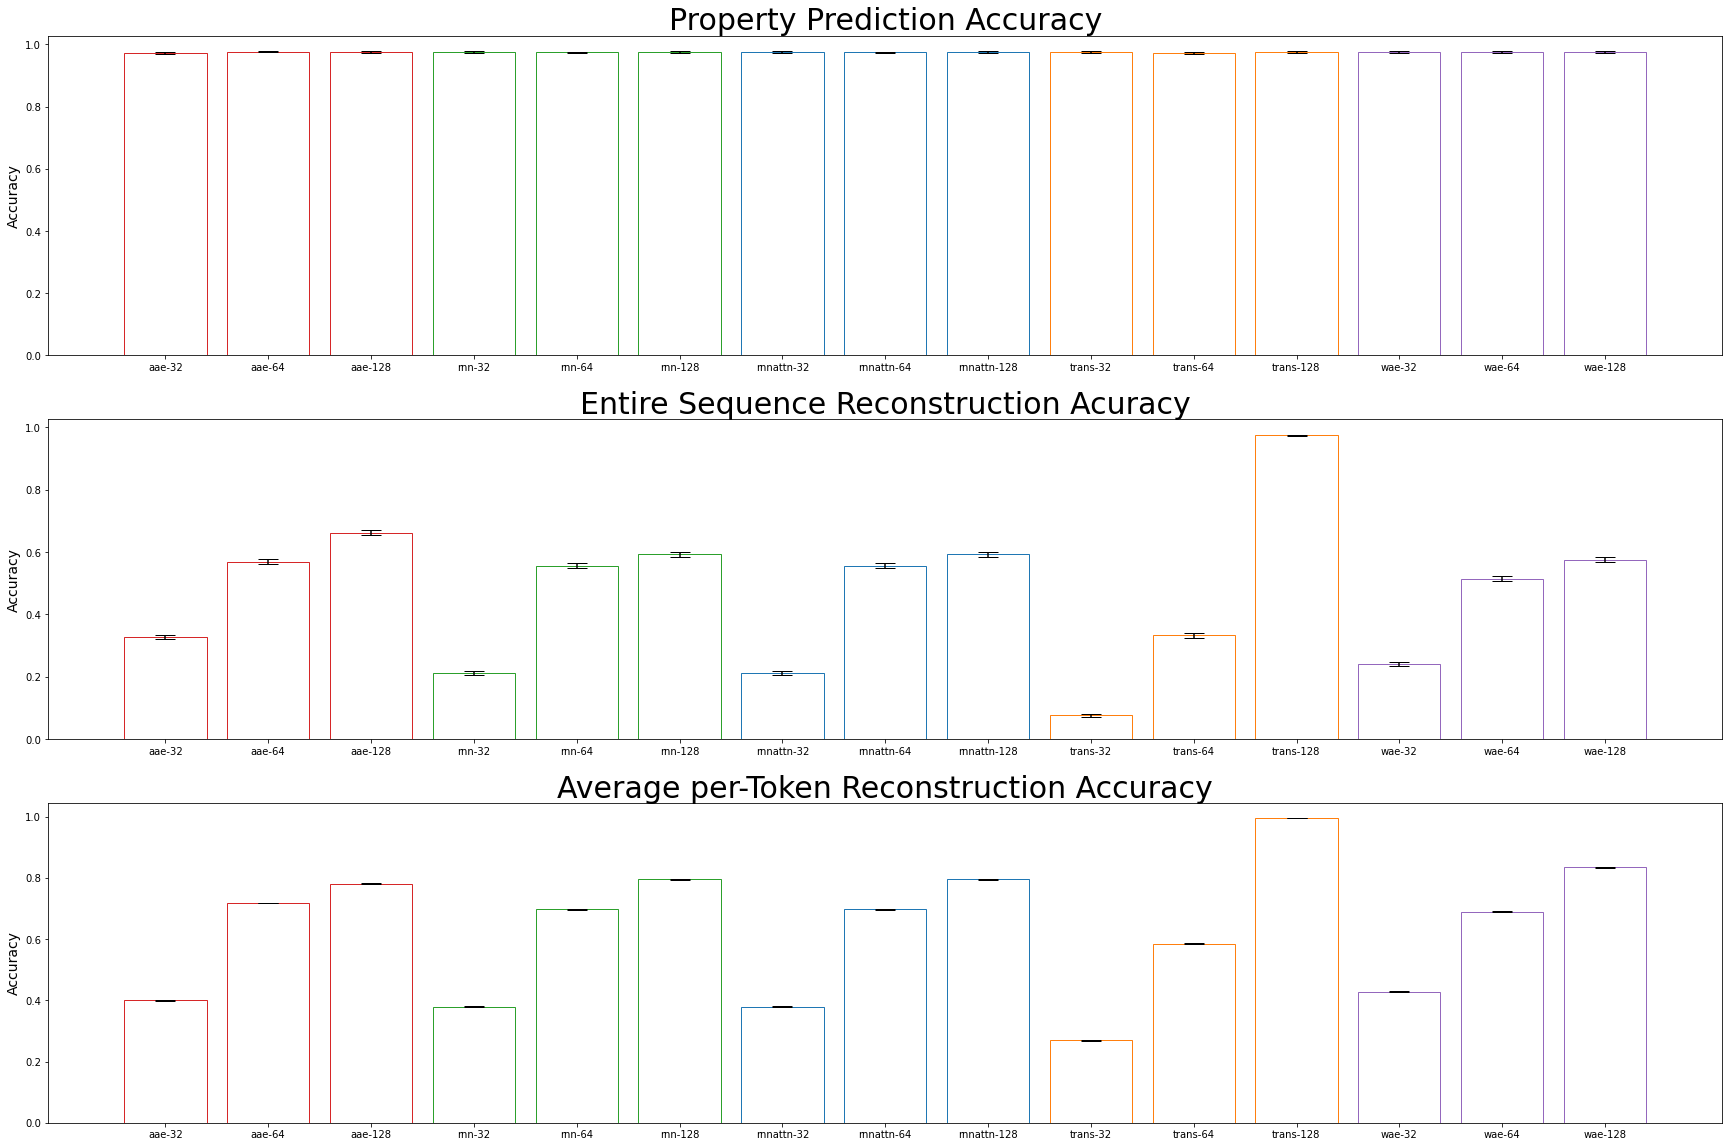

In [37]:
fig, ax = plt.subplots((len(acc_list)//len(namelist)-1),1, figsize=(30,20))

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
#plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
x_labels=['aae-32','aae-64','aae-128','rnn-32','rnn-64','rnn-128','rnnattn-32','rnnattn-64','rnnattn-128',
         'trans-32','trans-64','trans-128','wae-32','wae-64','wae-128']

for col in range((len(acc_list)//len(namelist)-1)):
    ax[col].bar(x=x_labels,height=[elmt[0] for elmt in acc_list[col::(len(acc_list)//len(namelist))]],
                yerr=[[elmt[1] for elmt in acc_list[col::(len(acc_list)//len(namelist))]],
                      [elmt[2] for elmt in acc_list[col::(len(acc_list)//len(namelist))]]],
                fill=False,
                capsize=10,
                edgecolor=['tab:red','tab:red','tab:red',
                       'tab:green','tab:green','tab:green',
                       'tab:blue','tab:blue','tab:blue',
                       'tab:orange','tab:orange','tab:orange',
                       'tab:purple','tab:purple','tab:purple']
               ) 
    ax[col].set_title(acc_list[col::(len(acc_list)//len(namelist))][0][-1])
    ax[col].set_ylabel('Accuracy')
plt.savefig('bar_metrics.jpg', transparent=True, dpi=200)
plt.show()

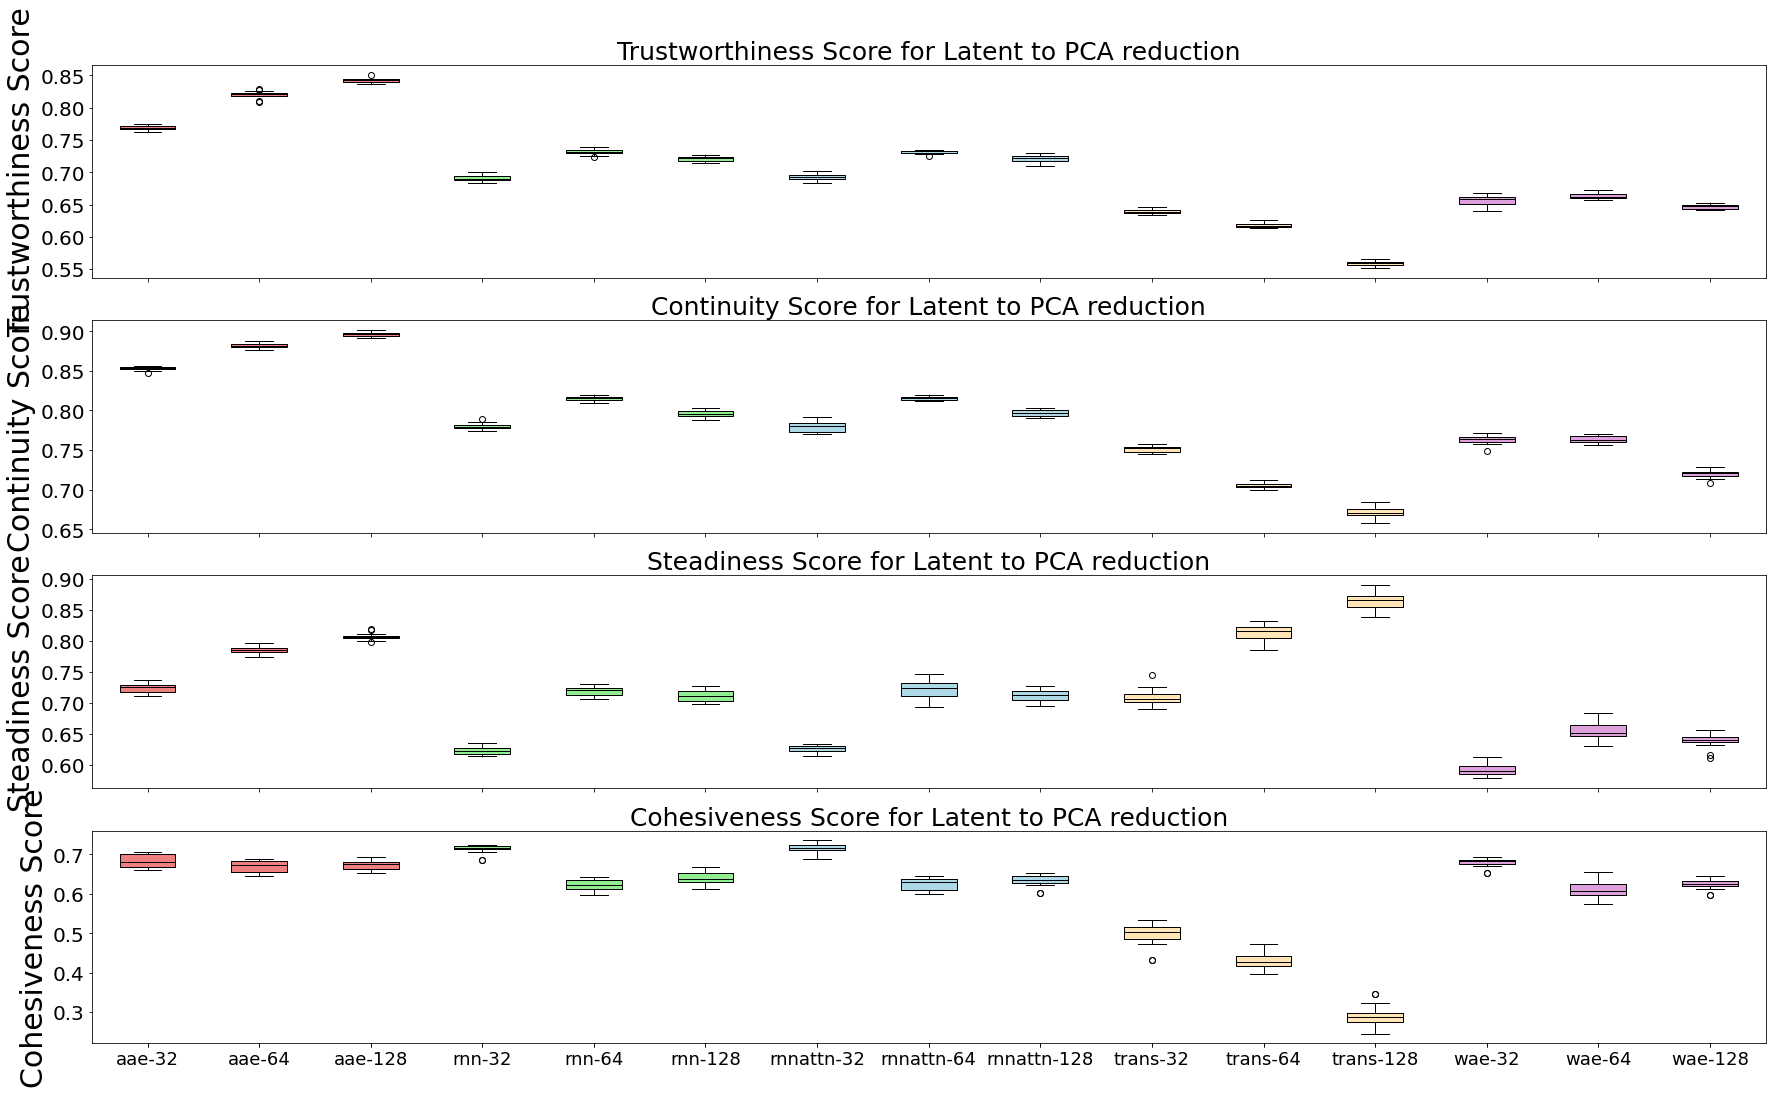

In [38]:
fig, ax = plt.subplots(4,1, figsize=(30,18))

color_list =['lightcoral','lightcoral','lightcoral',
             'lightgreen','lightgreen','lightgreen',
             'lightblue','lightblue','lightblue',
             'moccasin','moccasin','moccasin',
             'plum','plum','plum']
title_list=['Average Entropy of the Latent Space', 'Silhouette Score for Latent Memories and Peptide Functions',
           'Silhouette Score for PCA-reduced memories and Peptide Functions', 
            'Trustworthiness Score for Latent to PCA reduction', 'Continuity Score for Latent to PCA reduction',
           'LCMC Score for Latent to PCA reduction', 'Steadiness Score for Latent to PCA reduction',
           'Cohesiveness Score for Latent to PCA reduction']
y_labels=['Average Entropy', 'Silhouette Score','Silhouette Score','Trustworthiness Score','Continuity Score',
         'LCMC Score','Steadiness Score', 'Cohesiveness Score']
x_labels=['aae-32','aae-64','aae-128','rnn-32','rnn-64','rnn-128','rnnattn-32','rnnattn-64','rnnattn-128',
         'trans-32','trans-64','trans-128','wae-32','wae-64','wae-128']

SMALL_SIZE = 9
MEDIUM_SIZE = 15
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels

skip=0
for col in range(5):
    if col==2:
        skip-=1
        continue
    if col==4:
        box = ax[col+skip].boxplot(x=[elmt[0] for elmt in metric_list[col+3::(len(metric_list)//len(namelist))]],
                                   labels=x_labels, patch_artist=True) 
    box = ax[col+skip].boxplot(x=[elmt[0] for elmt in metric_list[col+3::(len(metric_list)//len(namelist))]],
                               labels=['' for item in range(15)],patch_artist=True) 
    for patch,color in zip(box['boxes'],color_list): patch.set_facecolor(color)
    plt.setp(box['medians'],color='black')
    ax[col+skip].set_title(title_list[col+3])
    ax[col+skip].set_ylabel(y_labels[col+3])
plt.savefig('pca_metrics.jpg', transparent=True,dpi=200)
plt.show()